# Project Work, Part 3 - Data Quality
## 1. Introduction
This project involves analyzing data in a Jupyter Notebook and creating a multi-page online app with Streamlit, with all work and code shared on GitHub. AI tools (e.g., ChatGPT) were utilized during the project to clarify requirements and to gain a deeper understanding of the technologies used.

- Task: Analysis of Norwegian electricity production (Elhub) and meteorological data (Open‑Meteo API).
- Goal: automate data collection, perform time‑series decomposition, periodic analysis, and anomaly detection; then visualize results in a Jupyter Notebook and Streamlit dashboard.

## 2. Repository and App Links
- GitHub: https://github.com/Indraadhikari/IND320_Indra
- Streamlit app: https://ind320-k2r8aymxk9takanegm8e3y.streamlit.app

## 3. Project Overview
### 3.1 AI Usage Description
In this project, I used AI (ChatGPT) as a helpful assistant during development. It supported me in solving coding errors, generating code ideas, and improving my understanding of concepts. The AI explained topics such as STL decomposition, Discrete Cosine Transform (DCT) filtering, and Local Outlier Factor (LOF) anomaly detection, giving both theory and example code.

I also used it to debug Python and Streamlit issues, like fixing empty DataFrames, using st.session_state, avoiding runtime errors, and organizing the multi-page layout. During implementation, I followed AI suggestions to clean up functions, set better parameter defaults, and make the visualizations easier to read.

All AI outputs were carefully checked, tested, and modified to fit the project’s goals and my own coding style. Overall, the AI acted as a learning and support tool, helping me work faster and understand data analysis and software design more deeply.

### 3.2 Project Log
For the compulsory work, I began by defining representative cities for Norway’s five electricity price areas (NO1–NO5) and storing their latitude and longitude in a Pandas DataFrame. This mapping created the geographic foundation for the rest of the analyses. I then downloaded hourly electricity production data from the Elhub API for 2021, focusing on the *PRODUCTION_PER_GROUP_MBA_HOUR* dataset. The raw *JSON* responses were normalized into a clean DataFrame.

Next, I replaced my earlier CSV‑based meteorological import with live calls to the Open‑Meteo API. For each selected price area, the application automatically queries the API using the corresponding city’s coordinates, returning hourly temperature, precipitation, and wind observations for 2019 in a Notebook file and 2021 for the Streamlit app. The fetched data are transformed into a tidy format in a Pandas DataFrame and cached for efficient reuse.

Analytical development was divided into three main components, implemented and tested first in a Jupyter Notebook.
- Seasonal‑Trend decomposition using LOESS (STL): using the *statsmodels.tsa.seasonal.STL* class, I decomposed the production time series into trend, seasonal, and residual components.
- Spectrogram analysis: applying *scipy.signal.spectrogram*, I generated time–frequency plots to reveal changes in periodic behavior across the year.
- Outlier and Anomaly detection: I implemented a robust Statistical Process Control (SPC) method using *Median ± k × MAD* boundaries on filtered temperature data and applied the Local Outlier Factor (LOF) algorithm from *scikit‑learn* to identify precipitation anomalies.
Each analytical block was wrapped in a modular Python function with configurable parameters (area, group, window length, etc.) and tested interactively in the notebook before integration into the Streamlit app.

I then updated the Streamlit dashboard to follow the new required page order. The global area selector was moved to the second page (named *Energy Production(4)* in the app), ensuring that all subsequent analyses depend on the user’s chosen region. Between existing pages, I added *new A (STL and Spectrogram(A))* and *new B (Outliers and Anomalies (B))* pages, each built with *st.tabs()* for navigation. Both pages render Matplotlib plots directly and display them. Communication between pages is managed through *st.session_state*, allowing the selected price area imported meteorological data and production data to persist throughout the session.

The completed workflow demonstrates a full data pipeline: acquiring data dynamically via APIs, performing time‑series analysis, detecting anomalies, and presenting interactive results through a structured Streamlit interface and Jupyter Notebook.

# 4. Importing Libraries

In [41]:
import requests 
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram

## 5. Data Extraction

### 5.1 Extracting data from Elhub API

In [42]:
headers = {    
    
}

endpoint = "https://api.elhub.no/energy-data/v0/"
entity = 'price-areas'
dataset = "PRODUCTION_PER_GROUP_MBA_HOUR"
#startdate = '2021-01-01T00:20:00%2B02:00'
#enddate = '2021-01-31T23:59:59%2B02:00'
year = 2021

In [43]:
dates = []
# accessing the data for a month at a time as Endpoint does not allow us to get for a whole year.
for month in range(1, 13):
    # Get number of days in month
    _, last_day = calendar.monthrange(year, month)
    
    # Format month and day properly (e.g. 01, 02, …)
    startdate = f"{year}-{month:02d}-01T00:20:00%2B02:00"
    enddate = f"{year}-{month:02d}-{last_day:02d}T23:59:59%2B02:00"
    
    dates.append((startdate, enddate))

all_data = []

for startdate, enddate in dates:
    #print(f"Start: {start}   End: {end}")
    data = []
    response = requests.get(f"{endpoint}{entity}?dataset={dataset}&startDate={startdate}&endDate={enddate}", headers=headers)
    #print(response.status_code)
    data = response.json()
    #data['data'][1]['attributes']['productionPerGroupMbaHour']
    for i in data['data']:
        all_data.extend(i['attributes']['productionPerGroupMbaHour'])
elbub_df = pd.DataFrame(all_data)
print(elbub_df.shape)

(215059, 6)


In [44]:
elbub_df.columns

Index(['endTime', 'lastUpdatedTime', 'priceArea', 'productionGroup',
       'quantityKwh', 'startTime'],
      dtype='object')

### 5.2 Assigning price area with a city name and inserting to elhub dataframe

In [45]:
data = {
    "priceArea": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.9127, 58.1467, 63.4305, 69.6489, 60.393],
    "longitude": [10.7461, 7.9956, 10.3951, 18.9551, 5.3242]
}

mapping_df = pd.DataFrame(data)
print(mapping_df)

  priceArea          city  latitude  longitude
0       NO1          Oslo   59.9127    10.7461
1       NO2  Kristiansand   58.1467     7.9956
2       NO3     Trondheim   63.4305    10.3951
3       NO4        Tromsø   69.6489    18.9551
4       NO5        Bergen   60.3930     5.3242


In [46]:
#merging two dataframe
production_df = pd.merge(elbub_df, mapping_df, on='priceArea', how='left')

# Parse and sort the time column
production_df['startTime'] = pd.to_datetime(production_df['startTime'], utc=True)
merged_df = production_df.sort_values('startTime')

production_df.tail()

,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh,startTime,city,latitude,longitude
215054,2021-12-31T20:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 18:00:00+00:00,Bergen,60.393,5.3242
215055,2021-12-31T21:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 19:00:00+00:00,Bergen,60.393,5.3242
215056,2021-12-31T22:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 20:00:00+00:00,Bergen,60.393,5.3242
215057,2021-12-31T23:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 21:00:00+00:00,Bergen,60.393,5.3242
215058,2022-01-01T00:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 22:00:00+00:00,Bergen,60.393,5.3242


### 5.4 Extracting weathers data from *open.meteo* API

In [47]:
def get_weather_data(lat, lon, year):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "precipitation", "windspeed_10m", "wind_gusts_10m", "wind_direction_10m"],  # example variables
        "timezone": "Europe/Oslo"
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data["hourly"])
    df = df.rename(columns={'temperature_2m': 'temperature_2m (°C)', 'windspeed_10m': 'wind_speed_10m (m/s)', 
                             'precipitation': 'precipitation (mm)','wind_gusts_10m': 'wind_gusts_10m (m/s)', 
                             'wind_direction_10m': 'wind_direction_10m (°)'})
    return df

bergen_lat = 60.39
bergen_lon = 5.32

df_bergen_2019 = get_weather_data(bergen_lat, bergen_lon, 2019)
df_bergen_2019.head()


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01T00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01T01:00,5.8,0.2,41.0,107.3,278
2,2019-01-01T02:00,6.1,0.7,42.0,112.0,286
3,2019-01-01T03:00,6.3,0.5,40.9,105.8,298
4,2019-01-01T04:00,5.8,1.1,41.2,110.2,315


In [48]:
df_bergen_2019.shape

(8760, 6)

# 6. Outliers and Anomalies:

### 6.1 Temperature Outliers via DCT High-pass Filtering & Robust SPC

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def analyze_temperature_outliers(
    df,
    time_col='time',
    temp_col='temperature_2m (°C)',
    freq_cutoff=10, #Number of low-frequency DCT components to remove (default=10).
    k=3, #Number of robust standard deviations (MAD scaled) for SPC limits (default=3)

    #plot=True # plot by default, not an optional but it is nice to have optional with default value.
):
    """
    Returns
    outliers_df : DataFrame of outlier rows (with SATV column)
    stats : dict of summary statistics
    fig : matplotlib figure
    """

    #  Prepare data 
    data = df.copy() #This will speed up the plot process as it copy all data once and work with it
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.sort_values(time_col).reset_index(drop=True)

    temps = data[temp_col].astype(float).values

    #  DCT high-pass filter 
    coeff = dct(temps, norm='ortho')
    highpass = np.copy(coeff)
    highpass[:freq_cutoff] = 0.0  # remove low-frequency (seasonal) components
    satv = idct(highpass, norm='ortho')  # Seasonally Adjusted Temperature Variations

    #  Robust SPC limits 
    median_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - median_satv))
    robust_sigma = 1.4826 * mad_satv  #(robust_sigma = 1.4826; For a formal data- lecture)
    upper = median_satv + k * robust_sigma
    lower = median_satv - k * robust_sigma

    #  Identify outliers 
    outlier_mask = (satv > upper) | (satv < lower)
    outliers_df = data.loc[outlier_mask].copy()
    outliers_df.loc[:, 'SATV'] = satv[outlier_mask]

    fig, ax = plt.subplots(figsize=(12, 6))

    #  Plot raw temperatures
    ax.plot(data[time_col], temps, color='orange', lw=1, label='Temperature')

    #  Compute trend estimate (approximate low‑frequency component)
    temp_trend = temps - satv

    #  Convert SPC limits from SATV back to temperature space
    upper_curve = temp_trend + upper
    lower_curve = temp_trend + lower

    #  Plot compensated SPC boundaries
    ax.plot(data[time_col], upper_curve, color='grey', linestyle='--', lw=1, label='Upper SPC limit')
    ax.plot(data[time_col], lower_curve, color='grey', linestyle='--', lw=1, label='Lower SPC limit')

    #  Mark outliers on the raw temperature curve
    ax.scatter(data.loc[outlier_mask, time_col], temps[outlier_mask],
            color='red', s=20, zorder=3, label='Outliers')

    ax.set_title("Temperature Outliers via DCT High‑pass Filtering & Robust SPC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.tight_layout()

    #  Summary 
    stats = {
        'n_points': len(data),
        'n_outliers': int(outlier_mask.sum()),
        'proportion_outliers': float(outlier_mask.sum()) / len(data),
        'median_SATV': float(median_satv),
        'MAD_SATV': float(mad_satv),
        'robust_sigma': float(robust_sigma),
        'upper_limit_SATV': float(upper),
        'lower_limit_SATV': float(lower)
    }

    #if plot:
    return outliers_df, stats, fig
    #return outliers_df, stats

n_points:8760
n_outliers:139
proportion_outliers:0.015867579908675798
median_SATV:-0.26469996833870235
MAD_SATV:2.154906962579277
robust_sigma:3.1948650627200363
upper_limit_SATV:9.319895219821406
lower_limit_SATV:-9.84929515649881


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°),SATV
652,2019-01-28 04:00:00,-9.0,0.0,6.5,12.6,90,-11.075845
653,2019-01-28 05:00:00,-10.6,0.0,5.2,10.4,74,-12.678163
654,2019-01-28 06:00:00,-11.3,0.0,5.4,11.5,82,-13.380481
655,2019-01-28 07:00:00,-11.8,0.0,5.4,11.9,90,-13.882799
656,2019-01-28 08:00:00,-11.6,0.0,5.4,12.6,94,-13.685116


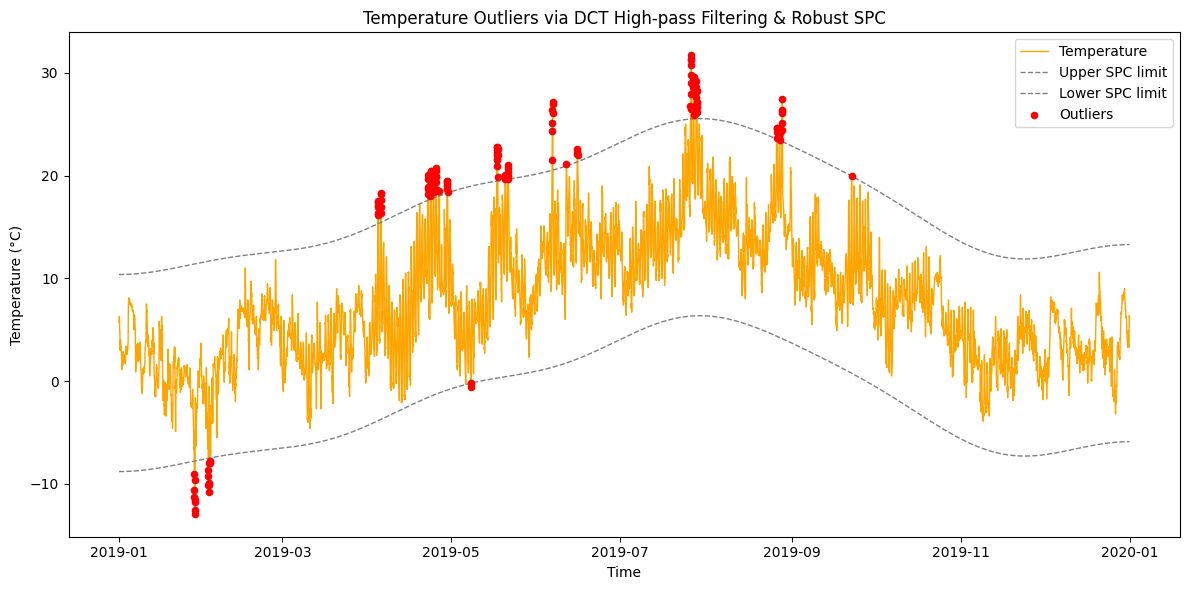

In [59]:
out_temp, stats_temp, fig_temp = analyze_temperature_outliers(df_bergen_2019)
for i in stats_temp:
    print(f"{i}:{stats_temp[i]}")
out_temp.head()

### 6.2 Precipitation Anomalies via Local Outlier Factor

In [51]:
def analyze_precipitation_anomalies(
    df,
    time_col='time', #Column name for timestamps
    precip_col='precipitation (mm)', #Column name for precipitation values
    proportion=0.01 #Expected proportion of anomalies (0-1); 1%
):
    """
    Returns
    outlier_df : DataFrame containing only the detected anomalies
    stats : Summary statistics about anomalies
    fig : matplotlib.figure.Figure
    """
    
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)
    
    precip = df[precip_col].fillna(0).values.reshape(-1, 1)

    #  Apply LOF (Local Outlier Factor) 
    lof = LocalOutlierFactor(contamination=proportion)
    labels = lof.fit_predict(precip)
    mask = labels == -1  # -1 means anomaly (outlier)
    
    # Extract anomalies
    outlier_df = df[mask].copy()
    outlier_df['LOF_Score'] = lof.negative_outlier_factor_[mask]

    #  Plot 
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df[time_col], df[precip_col], label='Precipitation', color='blue')
    ax.scatter(df.loc[mask, time_col], df.loc[mask, precip_col],
                   color='red', label='Anomalies (LOF)', zorder=3)
    ax.set_title("Precipitation Anomalies via Local Outlier Factor")
    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.legend()
    plt.tight_layout()

    #  Summary Statistics 
    stats = {
        'n_points': len(df),
        'n_anomalies': len(outlier_df),
        'proportion_anomalies': round(len(outlier_df) / len(df), 4),
        'mean_precipitation': df[precip_col].mean(),
        'mean_anomalies': outlier_df[precip_col].mean() if len(outlier_df) > 0 else None
    }

    #  Return Results 
    return outlier_df, stats, fig

n_points:8760
n_anomalies:80
proportion_anomalies:0.0091
mean_precipitation:0.24651826484018266
mean_anomalies:3.5387499999999994


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°),LOF_Score
86,2019-01-04 14:00:00,7.9,2.4,16.6,45.0,304,-1.000000e+00
88,2019-01-04 16:00:00,8.0,2.3,18.0,47.2,323,-1.000000e+08
477,2019-01-20 21:00:00,1.3,3.8,21.0,54.4,158,-1.070580e+00
1026,2019-02-12 18:00:00,4.3,3.3,19.0,53.3,161,-1.201389e+00
1227,2019-02-21 03:00:00,6.3,2.4,15.0,42.8,159,-1.000000e+00


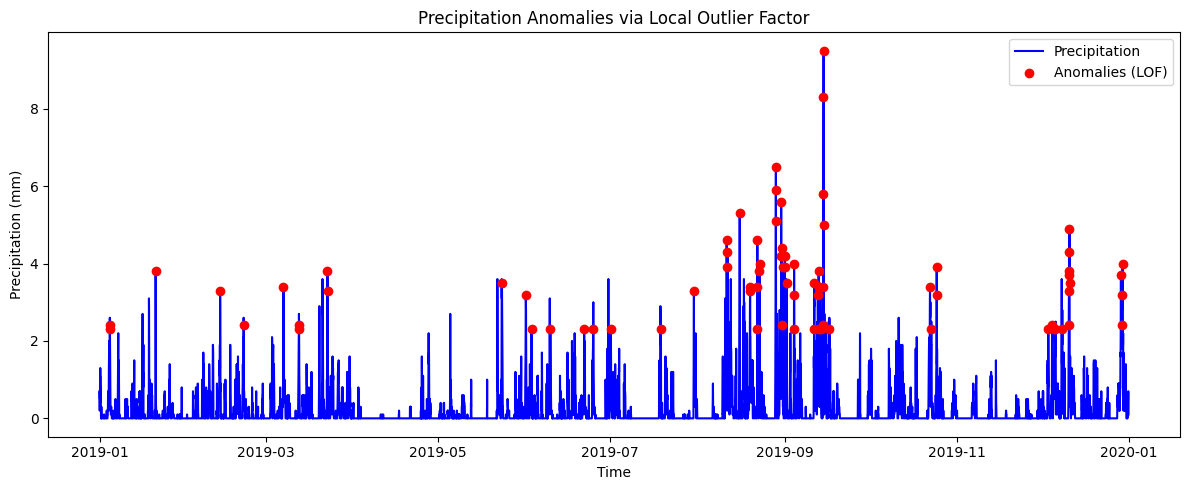

In [52]:
out_precip, stats_precip, fig_precip = analyze_precipitation_anomalies(df_bergen_2019)
for i in stats_precip:
    print(f"{i}:{stats_precip[i]}")
out_precip.head()

### 6.3 Seasonal-Trend decomposition using LOESS (STL)

In [53]:
production_df.head(2)

,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh,startTime,city,latitude,longitude
0,2021-01-01T02:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2494728.0,2021-01-01 00:00:00+00:00,Oslo,59.9127,10.7461
1,2021-01-01T03:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2486777.5,2021-01-01 01:00:00+00:00,Oslo,59.9127,10.7461


In [54]:
def stl_decomposition_by_area(
    production_df,
    city='Oslo', # price area (every price area is now assigned with city code)
    group='wind', # production group (e.g., 'hydro', 'wind', 'other')
    time_col='startTime',
    value_col='quantityKwh',
    period=24, # int, number of time steps per seasonal cycle 
    seasonal=12, # int, smoothness for seasonal component
    trend=365, # int, smoothness for long-term trend
    robust=True # bool, make LOESS robust to outliers
):
    #electricity price area, production group, period length, seasonal smoother, trend smoother and robust (true/false) be parameters,
    """
    Perform STL decomposition for a specific price area and production group.
    
    Returns
    result : STL decomposition object
    fig : matplotlib figure
    """

    # Subset data
    sub = production_df[(production_df['city'] == city) &
             (production_df['productionGroup'].str.lower() == group.lower())].copy()

    # Sort and check
    sub = sub.sort_values(time_col)
    sub[time_col] = pd.to_datetime(sub[time_col],utc=True)
    sub = sub.set_index(time_col)

    # Perform STL
    stl = STL(
        sub[value_col],
        period=period,
        seasonal=seasonal,
        trend=trend,
        robust=robust
    )
    result = stl.fit()

    fig = None
    fig = result.plot()
    fig.set_size_inches(10, 7)
    plt.suptitle(f"STL Decomposition — {city} ({group.title()})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return result, fig

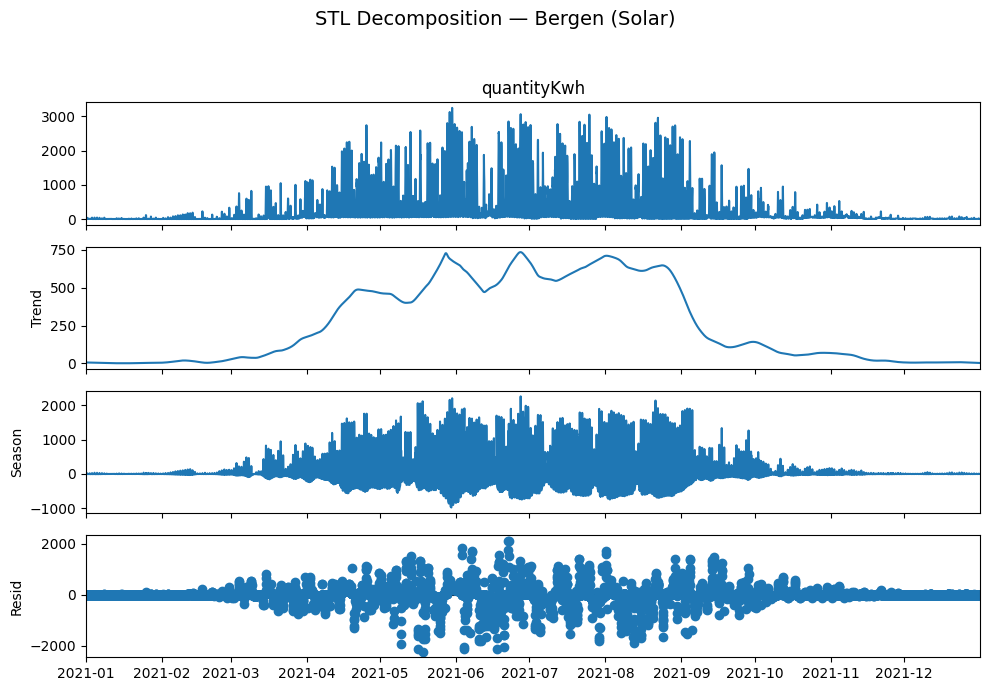

In [55]:
result, fig = stl_decomposition_by_area(
    production_df,  # dataframe from part 1
    time_col='startTime',
    value_col='quantityKwh',
    city='Bergen',
    group='solar',
    period=24,       # daily cycle
    seasonal=5,     # seasonal smoothing
    trend=365,       # yearly smooth trend
    robust=True
)

#print("Trend =", result.trend)
#print("seasonal =", result.seasonal)
#print("resid =", result.resid)

### 6.4 Spectrogram based on production data

In [56]:
def production_spectrogram(
    production_df,
    area='NO1', # price area (we can use city as STL)
    group='hydro',
    time_col='startTime',
    value_col='quantityKwh',
    window_length=256, # Controls resolution. Larger windows give better frequency (but worse time precision).
    overlap=128 # Overlap between windows.
):
    """
    Create a spectrogram based on production data for a given price area and group.

    Returns
    f : np.ndarray (Array of sample frequencies)
    t : np.ndarray (Array of segment times)
    Sxx : np.ndarray (Spectrogram intensity matrix)
    fig : matplotlib figure
    """

    #  Filter area and group 
    sub = production_df[(production_df['priceArea'] == area) &
             (production_df['productionGroup'].str.lower() == group.lower())].copy()

    #  Sort & clean signal 
    sub = sub.sort_values(time_col)
    sub[time_col] = pd.to_datetime(sub[time_col], utc=True)
    sub = sub.set_index(time_col)
    signal = sub[value_col].values

    #signal = np.nan_to_num(signal)

    #  Compute Spectrogram 
    fs = 1.0  # sampling frequency = 1 sample per time step (hourly)
    f, t, Sxx = spectrogram(
        signal,
        fs=fs,
        nperseg=window_length,
        noverlap=overlap,
        scaling='density'
    )

    fig = None
    fig, ax = plt.subplots(figsize=(10,5))

    # convert to dB scale for better visualization
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)

    im = ax.pcolormesh(t, f, Sxx_dB, shading='auto', cmap='viridis')
    plt.colorbar(im, ax=ax, label='Power (dB)')
    ax.set_ylabel('Frequency [cycles per time unit]')
    ax.set_xlabel('Time [index]')
    ax.set_title(f"Spectrogram — {area} ({group.title()})")
    plt.tight_layout()

    return f, t, Sxx, fig

[0.         0.00595238 0.01190476 0.01785714 0.02380952 0.0297619
 0.03571429 0.04166667 0.04761905 0.05357143 0.05952381 0.06547619
 0.07142857 0.07738095 0.08333333 0.08928571 0.0952381  0.10119048
 0.10714286 0.11309524 0.11904762 0.125      0.13095238 0.13690476
 0.14285714 0.14880952 0.1547619  0.16071429 0.16666667 0.17261905
 0.17857143 0.18452381 0.19047619 0.19642857 0.20238095 0.20833333
 0.21428571 0.2202381  0.22619048 0.23214286 0.23809524 0.24404762
 0.25       0.25595238 0.26190476 0.26785714 0.27380952 0.2797619
 0.28571429 0.29166667 0.29761905 0.30357143 0.30952381 0.31547619
 0.32142857 0.32738095 0.33333333 0.33928571 0.3452381  0.35119048
 0.35714286 0.36309524 0.36904762 0.375      0.38095238 0.38690476
 0.39285714 0.39880952 0.4047619  0.41071429 0.41666667 0.42261905
 0.42857143 0.43452381 0.44047619 0.44642857 0.45238095 0.45833333
 0.46428571 0.4702381  0.47619048 0.48214286 0.48809524 0.49404762
 0.5       ]


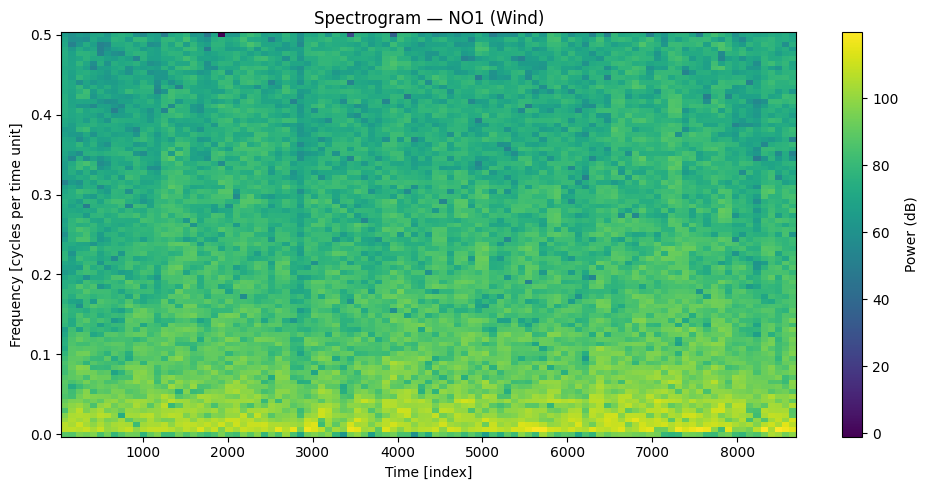

In [57]:
f, t, Sxx, fig = production_spectrogram(
    production_df,
    area='NO1',
    group='wind',
    window_length=168,  # one week (24h * 7)
    overlap=84          # 50% overlap
)

print(f)
#print(t)
#print(Sxx)